# Tensorflow Object Detection API and AWS Sagemaker

In this notebook, you will train and evaluate different models using the [Tensorflow Object Detection API](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/) and [AWS Sagemaker](https://aws.amazon.com/sagemaker/). 

If you ever feel stuck, you can refer to this [tutorial](https://aws.amazon.com/blogs/machine-learning/training-and-deploying-models-using-tensorflow-2-with-the-object-detection-api-on-amazon-sagemaker/).

## Dataset

We are using the [Waymo Open Dataset](https://waymo.com/open/) for this project. The dataset has already been exported using the tfrecords format. The files have been created following the format described [here](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#create-tensorflow-records). You can find data stored on [AWS S3](https://aws.amazon.com/s3/), AWS Object Storage. The images are saved with a resolution of 640x640.

In [1]:
%%capture
%pip install tensorflow_io sagemaker -U

In [ ]:
%pip show sagemaker

In [ ]:
import os
import sagemaker
from sagemaker.estimator import Estimator
from framework import CustomFramework

Save the IAM role in a variable called `role`. This would be useful when training the model.

In [ ]:
role = sagemaker.get_execution_role()
print(role)

In [5]:
# The train and val paths below are public S3 buckets created by Udacity for this project
inputs = {'train': 's3://cd2688-object-detection-tf2/train/', 
          'val': 's3://cd2688-object-detection-tf2/val/'} 

# Insert path of a folder in your personal S3 bucket to store tensorboard logs.
tensorboard_s3_prefix = 's3://object-detection-3/logs/'

## Container

To train the model, you will first need to build a [docker](https://www.docker.com/) container with all the dependencies required by the TF Object Detection API. The code below does the following:
* clone the Tensorflow models repository
* get the exporter and training scripts from the repository
* build the docker image and push it 
* print the container name

In [ ]:
%%bash

# clone the repo and get the scripts
git clone https://github.com/tensorflow/models.git docker/models

# get model_main and exporter_main files from TF2 Object Detection GitHub repository
cp docker/models/research/object_detection/exporter_main_v2.py source_dir 
cp docker/models/research/object_detection/model_main_tf2.py source_dir

In [ ]:
# build and push the docker image. This code can be commented out after being run once.
# This will take around 10 mins.
image_name = 'tf2-object-detection'
!sh ./docker/build_and_push.sh $image_name

To verify that the image was correctly pushed to the [Elastic Container Registry](https://aws.amazon.com/ecr/), you can look at it in the AWS webapp. For example, below you can see that three different images have been pushed to ECR. You should only see one, called `tf2-object-detection`.
![ECR Example](../data/example_ecr.png)


In [ ]:
# display the container name
with open (os.path.join('docker', 'ecr_image_fullname.txt'), 'r') as f:
    container = f.readlines()[0][:-1]

print(container)

## Pre-trained model from model zoo

As often, we are not training from scratch and we will be using a pretrained model from the TF Object Detection model zoo. You can find pretrained checkpoints [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Because your time is limited for this project, we recommend to only experiment with the following models:
* SSD MobileNet V2 FPNLite 640x640	
* SSD ResNet50 V1 FPN 640x640 (RetinaNet50)	
* Faster R-CNN ResNet50 V1 640x640	
* EfficientDet D1 640x640	
* Faster R-CNN ResNet152 V1 640x640	

In the code below, the EfficientDet D1 model is downloaded and extracted. This code should be adjusted if you were to experiment with other architectures.

In [ ]:
%%bash
mkdir /tmp/checkpoint
mkdir source_dir/checkpoint
wget -O /tmp/efficientdet.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz
tar -zxvf /tmp/efficientdet.tar.gz --strip-components 2 --directory source_dir/checkpoint efficientdet_d1_coco17_tpu-32/checkpoint

In [ ]:
%%bash
mkdir /tmp/checkpoint
mkdir source_dir/checkpoint
wget -O /tmp/ssd_resnet.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
tar -zxvf /tmp/ssd_resnet.tar.gz --strip-components 2 --directory source_dir/checkpoint ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint

In [ ]:
%%bash
mkdir /tmp/checkpoint
mkdir source_dir/checkpoint
wget -O /tmp/ssd_faster_rcnn.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
tar -zxvf /tmp/ssd_faster_rcnn.tar.gz --strip-components 2 --directory source_dir/checkpoint faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint

## Edit pipeline.config file

The [`pipeline.config`](source_dir/pipeline.config) in the `source_dir` folder should be updated when you experiment with different models. The different config files are available [here](https://github.com/tensorflow/models/tree/master/research/object_detection/configs/tf2).

>Note: The provided `pipeline.config` file works well with the `EfficientDet` model. You would need to modify it when working with other models.

## Launch Training Job

Now that we have a dataset, a docker image and some pretrained model weights, we can launch the training job. To do so, we create a [Sagemaker Framework](https://sagemaker.readthedocs.io/en/stable/frameworks/index.html), where we indicate the container name, name of the config file, number of training steps etc.

The `run_training.sh` script does the following:
* train the model for `num_train_steps` 
* evaluate over the val dataset
* export the model

Different metrics will be displayed during the evaluation phase, including the mean average precision. These metrics can be used to quantify your model performances and compare over the different iterations.

You can also monitor the training progress by navigating to **Training -> Training Jobs** from the Amazon Sagemaker dashboard in the Web UI.

In [ ]:
tensorboard_output_config = sagemaker.debugger.TensorBoardOutputConfig(
    s3_output_path=tensorboard_s3_prefix,
    container_local_output_path='/opt/training/'
)

estimator = CustomFramework(
    role=role,
    image_uri=container,
    entry_point='run_training.sh',
    source_dir='source_dir/',
    hyperparameters={
        "model_dir": "/opt/training",
        "pipeline_config_path": "pipeline.config",
        "num_train_steps": "2000",
        "sample_1_of_n_eval_examples": "1"
    },
    instance_count=1,
    instance_type='ml.g5.xlarge',
    tensorboard_output_config=tensorboard_output_config,
    disable_profiler=True,
    base_job_name='tf2-object-detection'
)

estimator.fit(inputs)

You should be able to see your model training in the AWS webapp as shown below:
![ECR Example](../data/example_trainings.png)







## Improve on the initial model

Most likely, this initial experiment did not yield optimal results. However, you can make multiple changes to the `pipeline.config` file to improve this model. One obvious change consists in improving the data augmentation strategy. The [`preprocessor.proto`](https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto) file contains the different data augmentation method available in the Tf Object Detection API. Justify your choices of augmentations in the write-up.

Keep in mind that the following are also available:
* experiment with the optimizer: type of optimizer, learning rate, scheduler etc
* experiment with the architecture. The Tf Object Detection API model zoo offers many architectures. Keep in mind that the pipeline.config file is unique for each architecture and you will have to edit it.
* visualize results on the test frames using the `2_deploy_model` notebook available in this repository.

In the cell below, write down all the different approaches you have experimented with, why you have chosen them and what you would have done if you had more time and resources. Justify your choices using the tensorboard visualizations (take screenshots and insert them in your write-up), the metrics on the evaluation set and the generated animation you have created with [this tool](../2_run_inference/2_deploy_model.ipynb).+

# SSD ResNet50 V1 FPN 640x640 (RetinaNet50)

## SSD ResNet50 V1 FPN 640x640 (RetinaNet50)

### Speed and Accuracy
the model offers a good balance between speed and accuracy, making it suitable for real-time applications.

### Single-Stage Approach
single-stage approach (directly predicting bounding boxes and class probabilities) makes room for faster inference times.

### Feature Pyramid Networks (FPN)
Wanted to test its effectiveness in Comparison to traditional approach

## If Given More Time and Resources

### Fine-tune
Experiment with different hyperparameters, such as learning rate, batch size, and optimizer, to optimize performance.

### Data Augmentation
Apply a wider range of data augmentation techniques, including random cropping, flipping, rotation, color jittering, and Gaussian noise, to improve model generalization.

####  Implement techniques like batching, asynchronous processing, and hardware acceleration to achieve real-time performance.

# faster_rcnn validation loss = 0.19 , train_loss = 0.16

Faster-RCNN performed the best, as expected from a 2 stage detection algorithm, they generally tend to be better in terms of empirical performance but lag behind in terms of real-time prdictions due to high amount of computations.

A lower training loss indicates the model is somewhat overfitting but as there is not a huge difference this falls with in acceptable range. To improve performance a numbver of activities can be undertaken, as metioned above. we can:

#### regularisation
#### Data Augmentation
#### Hyperparameter tuning
#### Implement a more complex Model Architecture

# SSD ResNet50 V1 FPN 640x640 (RetinaNet50)

## Precision
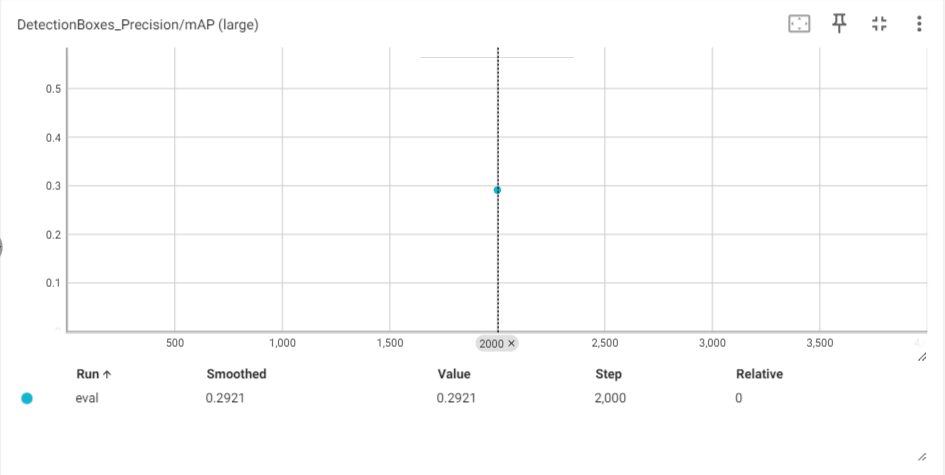

## Recall
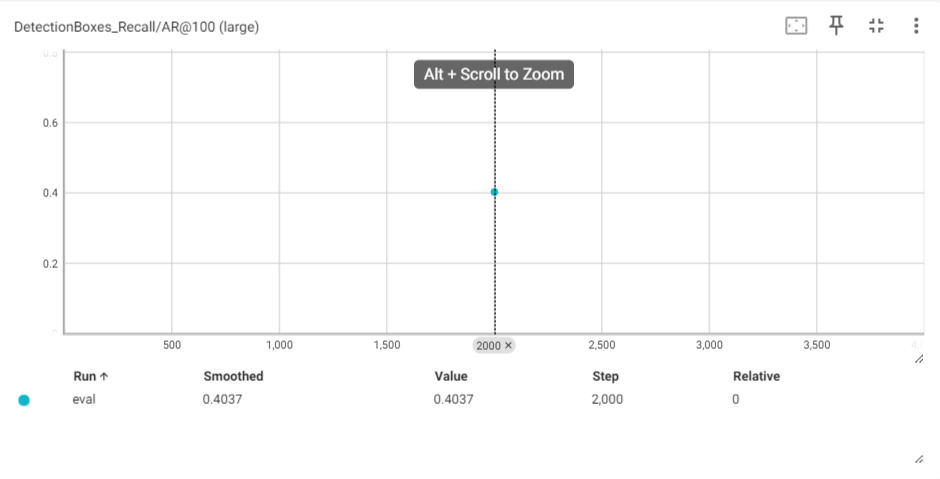

## Loss Curves
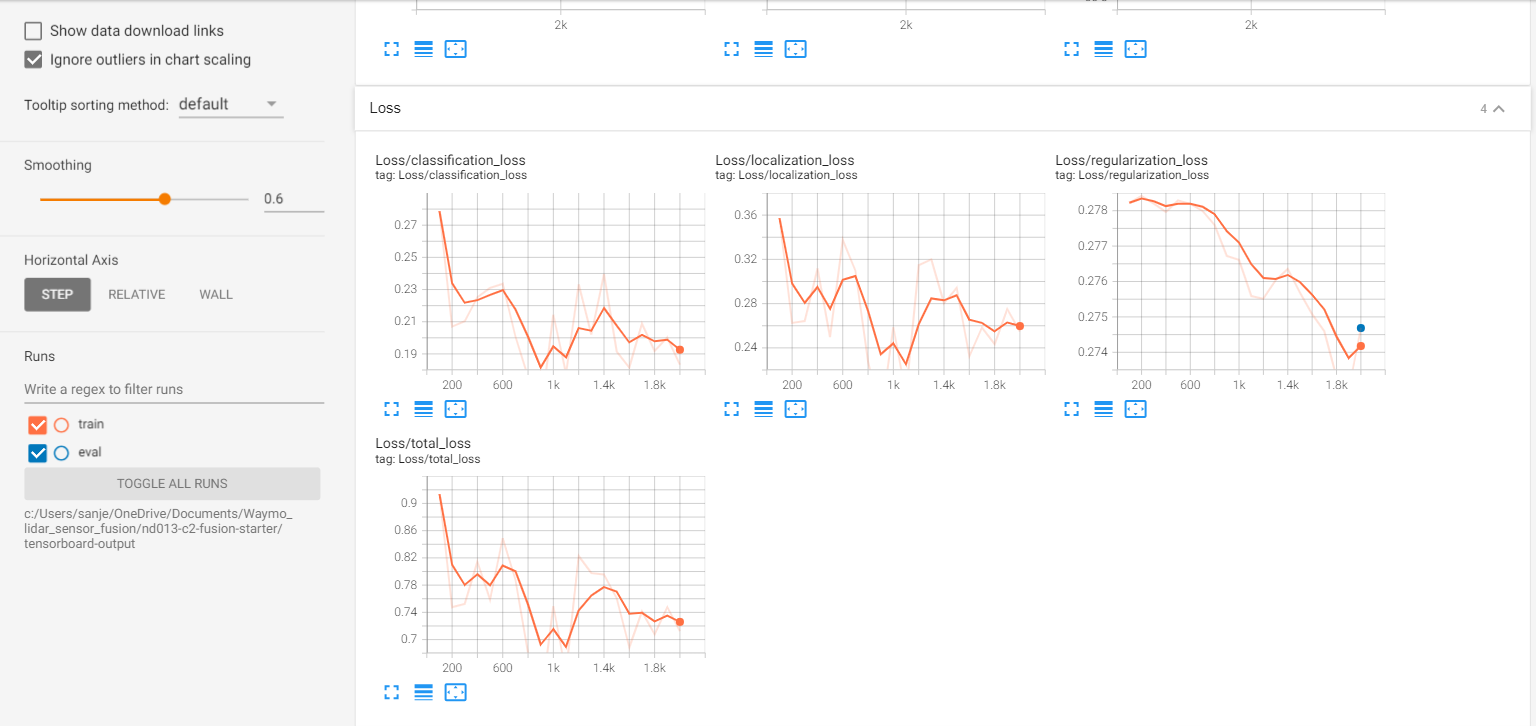

## Learning Rate Curve
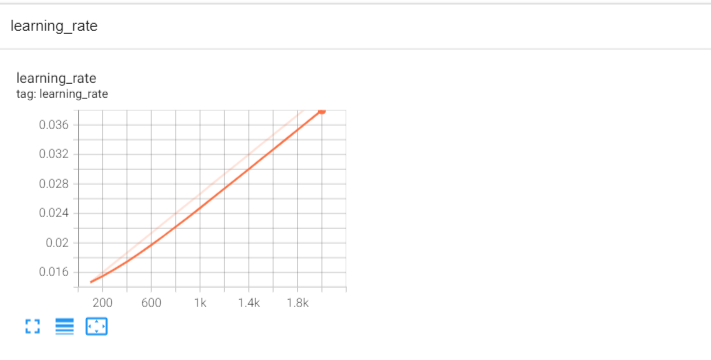